In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import pickle

In [50]:
PROJECT_PATH = Path(".").absolute().parent
PROJECT_PATH

PosixPath('/home/yuri/github.com/AoesJP/project_pokereader')

In [51]:
# img_path = str(PROJECT_PATH / "data/charizard.png")
# img_path = str(PROJECT_PATH / "data/poke2.png")
IMG_PATH = str(PROJECT_PATH / "data/white_bg/IMG_1498.jpeg")
# IMG_PATH = str(PROJECT_PATH / "data/poke1.png")
# IMG_PATH = str(PROJECT_PATH / "data/IMG_1460.jpeg")
IMG_PATH

'/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1498.jpeg'

In [52]:
IMG_SIZE = (512, 512)

In [53]:
def apply_blur(img, kernel: int = 7):
    img = cv2.convertScaleAbs(img)
    return cv2.GaussianBlur(img, (kernel, kernel), 0)

In [54]:
def mono_grad(image, shift):
    kernel = np.ones((shift, shift), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

In [55]:
def resize_with_fill(image: np.ndarray, target_width: int, target_height: int):
    original_height, original_width = image.shape[:2]

    # Calculate the ratio to scale the image
    ratio = min(target_width / original_width, target_height / original_height)

    # Calculate new size and resize the image
    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)
    resized_image = cv2.resize(image, (new_width, new_height))

    # Calculate padding to center the image
    top = (target_height - new_height) // 2
    bottom = target_height - new_height - top
    left = (target_width - new_width) // 2
    right = target_width - new_width - left

    # Pad the resized image to the desired size with black color
    padded_image = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_image

In [56]:
def flatten_color(img: np.ndarray) -> np.ndarray:
    return np.array([img[:, :, 0].flatten(), img[:, :, 1].flatten(), img[:, :, 2].flatten()]).T

In [57]:
def compress_img(img: np.ndarray, cluster: int = 8) -> np.ndarray:
    img_width = img.shape[0]
    img_height = img.shape[1]
    img_flatten = flatten_color(img)
    kmeans = KMeans(8)
    kmeans.fit(img_flatten)
    img_copressed = kmeans.cluster_centers_.astype(int)[kmeans.labels_]
    return img_copressed.reshape((img_width, img_height, 3)).astype(np.uint8)

In [58]:
def draw_contour(img, contour, points: bool = True, line_width: int = 2, point_size: int = 6):
    img_copy = img.copy()
    img_contour = cv2.drawContours(img_copy, [contour], -1, (50, 255, 0), line_width)
    if points:
        for point in contour:
            cv2.circle(img_contour, tuple(point[0]), point_size, (255, 0, 0), -1)
    plt.imshow(img_contour)

In [59]:
def remove_short_contours(contours, threshold: int = 300) -> list[np.ndarray]:
    results = []
    for contour in contours:
        length = cv2.arcLength(contour, True)
        if length > threshold:
            results.append(contour)

    return results

In [60]:
def smooth_contours(contours, epsilon: int = 5) -> list[np.ndarray]:
    new_contours = []
    for contour in contours:
        approx = cv2.approxPolyDP(contour, epsilon, True)
        new_contours.append(approx)

    return new_contours

In [61]:
def find_rectangle_contours(contours: tuple[np.ndarray], target_contour: np.ndarray, threshold=0.1):
    matches = []
    for contour in contours:
        length = cv2.arcLength(contour, True)
        match_power = cv2.matchShapes(contour, target_contour, cv2.CONTOURS_MATCH_I1, 0)
        if match_power <= threshold:
            matches.append([contour, match_power, length])

    return sorted(matches, key=lambda x: x[1])

In [62]:
def show_color(img):
    plt.imshow(img, vmin=0, vmax=255)

In [63]:
def show_grey(img):
    plt.imshow(img, cmap="grey", vmin=0, vmax=255)

In [64]:
def show_channels(img: np.ndarray):
    channels = img.shape[2]
    plt.figure(figsize=(6 * channels, 6))
    for i in range(channels):
        plt.subplot(int(f"1{channels}{i+1}"))
        plt.imshow(img[:, :, i], cmap="grey", vmin=0, vmax=255)

In [65]:
# frame_img = cv2.imread(str(PROJECT_PATH / "data/card_framing.png"))
# contours, hierarchy = cv2.findContours(
#     frame_img[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS
# )
# smooth_cont = cv2.approxPolyDP(contours[0], 1.6, True)
# draw_contour(frame_img, smooth_cont)

In [66]:
# with open(str(PROJECT_PATH / "data/base_contour.pickle"), mode="wb") as fo:
#     pickle.dump(smooth_cont, fo)

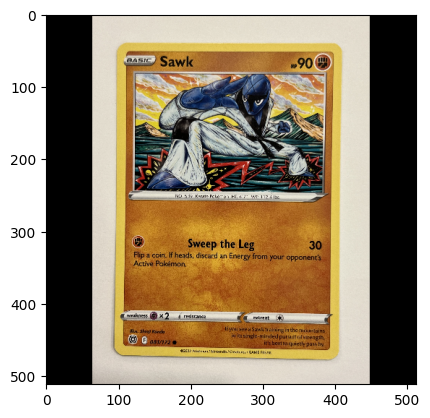

In [67]:
img = resize_with_fill(
    cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB), IMG_SIZE[0], IMG_SIZE[1]
)
show_color(img)

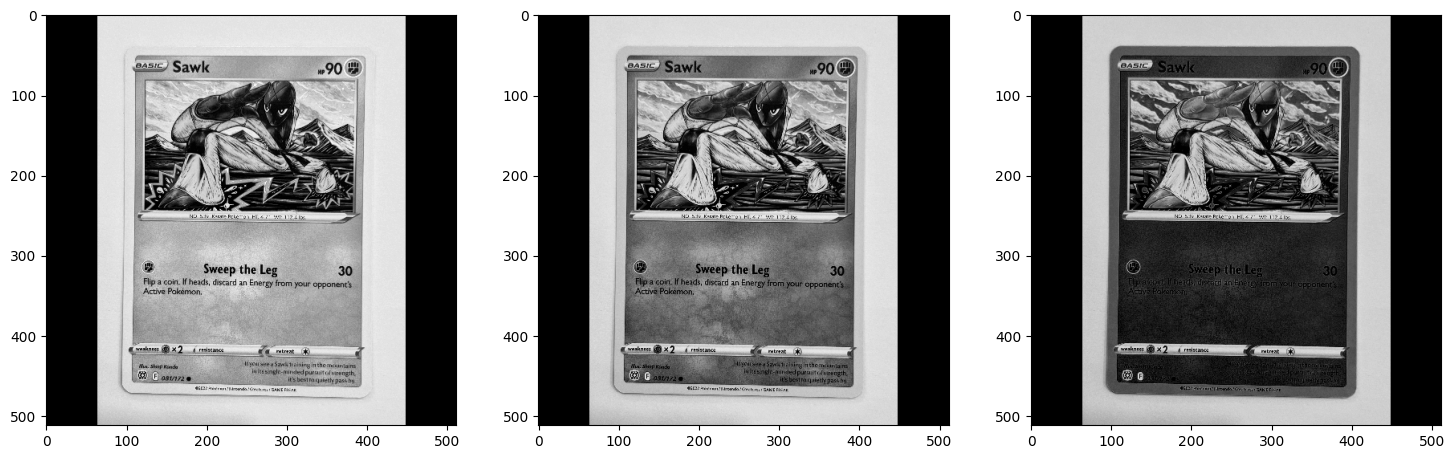

In [68]:
show_channels(img)

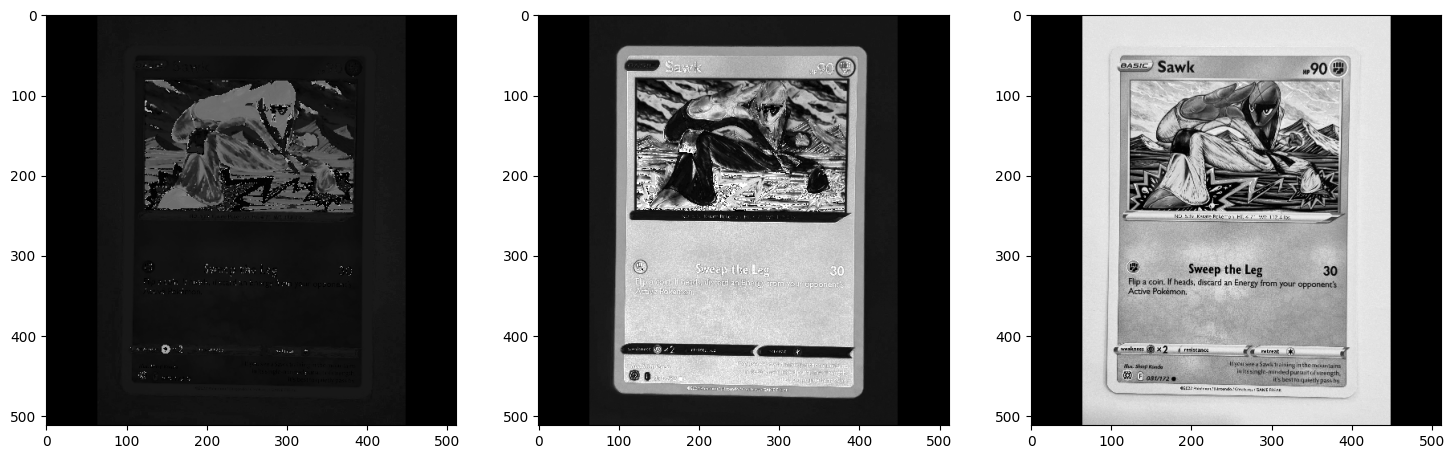

In [69]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
show_channels(img_hsv)

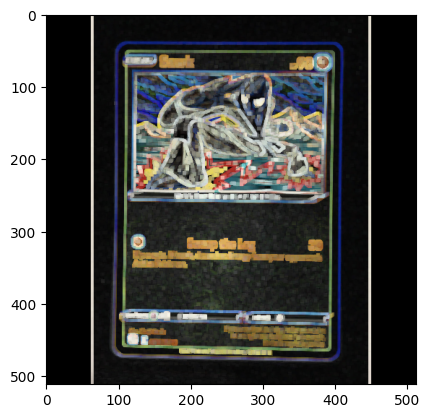

In [70]:
show_color(mono_grad(img, 5))

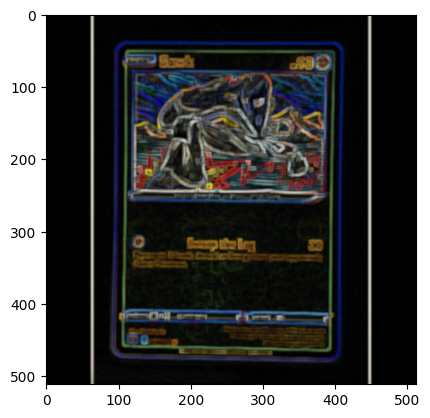

In [71]:
show_color(mono_grad(apply_blur(img, kernel=5), 5))

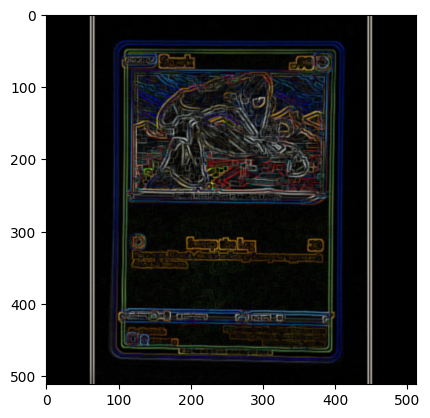

In [72]:
show_color(mono_grad(mono_grad(apply_blur(img, kernel=3), 5), 3))

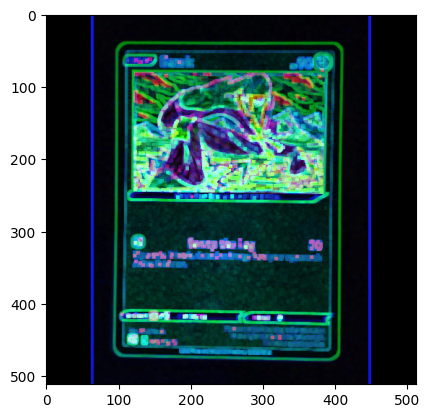

In [73]:
show_color(mono_grad(img_hsv, 5))

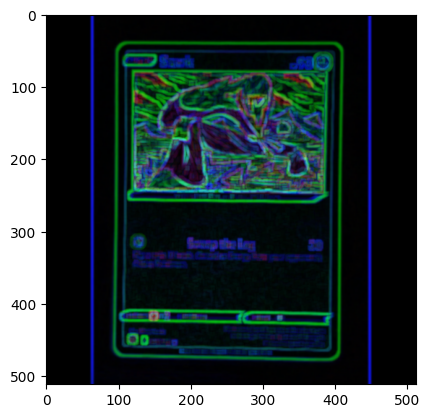

In [74]:
show_color(mono_grad(apply_blur(img_hsv, kernel=5), 5))

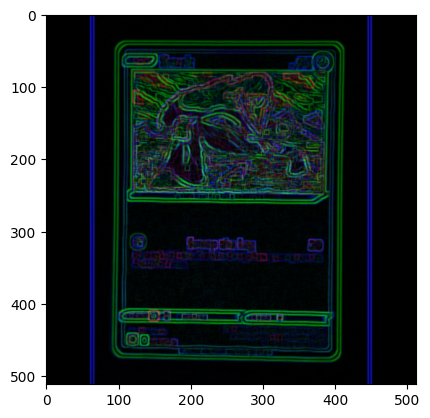

In [75]:
show_color(mono_grad(mono_grad(apply_blur(img_hsv, kernel=3), 5), 3))

In [76]:
# compressed_img = compress_img(img)
# show_channels(compressed_img)

In [77]:
# compressed_hsv_img = compress_img(img_hsv)
# show_channels(compressed_hsv_img)

In [78]:
# # Step 3: Extract the HSV values
# r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

# # Step 4: Visualize the points in HSV space using Plotly
# # Flatten the HSV channels
# r_flat = r.flatten().astype(float) / 255
# g_flat = g.flatten().astype(float) / 255
# b_flat = b.flatten().astype(float) / 255

# # Create a DataFrame for Plotly
# df = pd.DataFrame({"R": r_flat, "G": g_flat, "B": b_flat})

# # Plot using Plotly
# fig = px.scatter_3d(
#     df, x="R", y="G", z="B", color="R", title="RGB Color Space", size_max=1, width=600, height=600
# )
# fig.show()

In [79]:
# hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# # Step 3: Extract the HSV values
# h, s, v = hsv_image[:, :, 0], hsv_image[:, :, 1], hsv_image[:, :, 2]

# # Step 4: Visualize the points in HSV space using Plotly
# # Flatten the HSV channels
# h_flat = h.flatten().astype(float) / 255
# s_flat = s.flatten().astype(float) / 255
# v_flat = v.flatten().astype(float) / 255

# # Create a DataFrame for Plotly
# df = pd.DataFrame({"H": h_flat, "S": s_flat, "V": v_flat})

# # Plot using Plotly
# fig = px.scatter_3d(
#     df, x="H", y="S", z="V", color="H", title="HSV Color Space", size_max=1, width=600, height=600
# )
# fig.show()

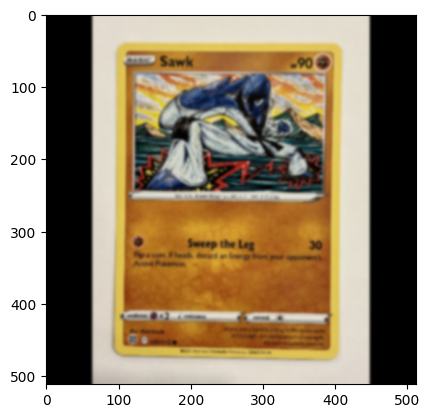

In [80]:
blurred_rgb = cv2.GaussianBlur(img, (9, 9), 0)
show_color(blurred_rgb)

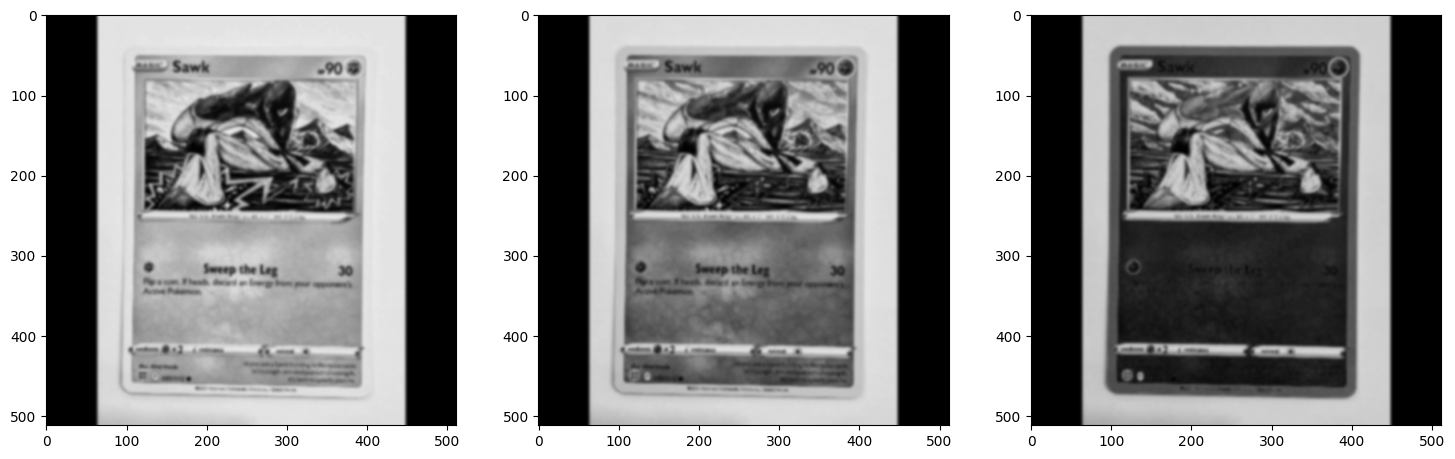

In [81]:
show_channels(blurred_rgb)

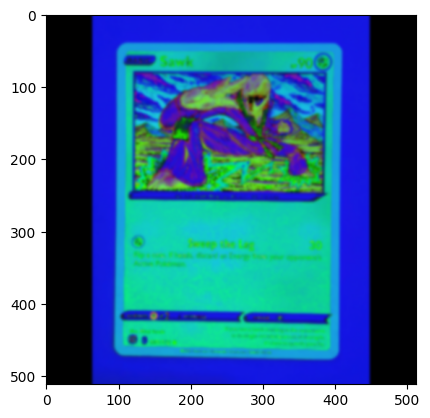

In [82]:
blurred_hsv = cv2.GaussianBlur(img_hsv, (9, 9), 0)
show_color(blurred_hsv)

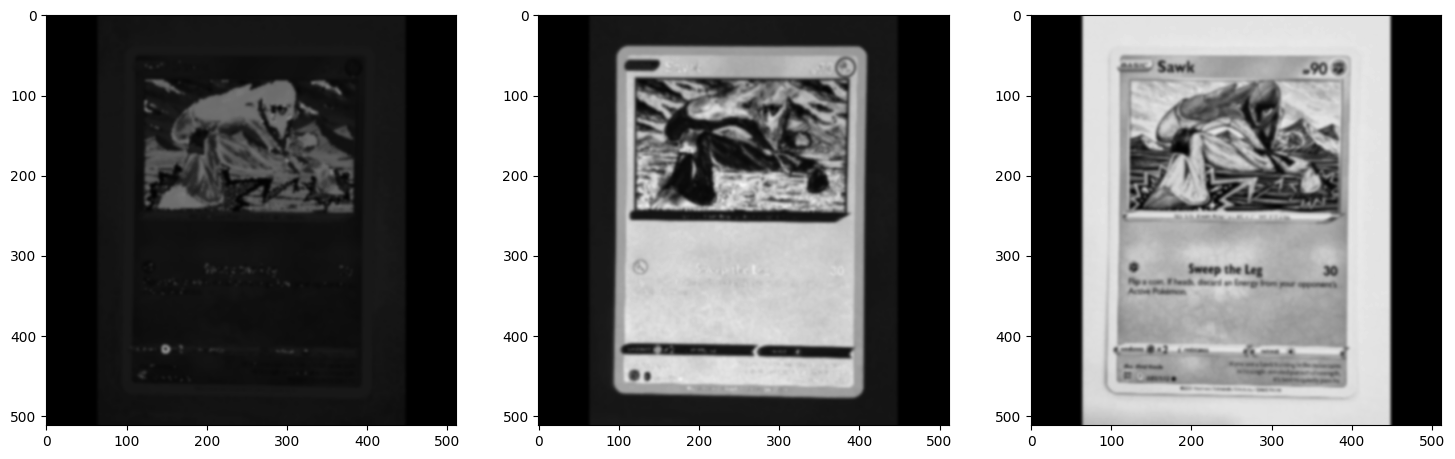

In [83]:
show_channels(blurred_hsv)

In [84]:
def apply_contrast(img, alpha=2, beta=-100):
    _ = img.astype("int16")
    # return np.clip(cv2.convertScaleAbs(_, alpha=alpha, beta=beta), 0, 255).astype(np.uint8)
    return np.clip((_ * alpha) + beta, 0, 255).astype(np.uint8)

In [85]:
alpha = 1.3
beta = -20

img_r = apply_contrast(blurred_rgb[:, :, 0], alpha=alpha, beta=beta)
img_g = apply_contrast(blurred_rgb[:, :, 1], alpha=alpha, beta=beta)
img_b = apply_contrast(blurred_rgb[:, :, 2], alpha=alpha, beta=beta)
img_h = apply_contrast(blurred_hsv[:, :, 0], alpha=alpha, beta=beta)
img_s = apply_contrast(blurred_hsv[:, :, 1], alpha=alpha, beta=beta)
img_v = apply_contrast(blurred_hsv[:, :, 2], alpha=alpha, beta=beta)

In [86]:
# ret, img_r = cv2.threshold(
#     blurred_rgb[:, :, 0],
#     0,
#     255,
#     cv2.THRESH_OTSU,
# )

# ret, img_g = cv2.threshold(
#     blurred_rgb[:, :, 1],
#     0,
#     255,
#     cv2.THRESH_OTSU,
# )

# ret, img_b = cv2.threshold(
#     blurred_rgb[:, :, 2],
#     0,
#     255,
#     cv2.THRESH_OTSU,
# )

# ret, img_h = cv2.threshold(
#     blurred_hsv[:, :, 0],
#     0,
#     255,
#     cv2.THRESH_OTSU,
# )

# ret, img_s = cv2.threshold(
#     blurred_hsv[:, :, 1],
#     0,
#     255,
#     cv2.THRESH_OTSU,
# )

# ret, img_v = cv2.threshold(
#     blurred_hsv[:, :, 2],
#     0,
#     255,
#     cv2.THRESH_OTSU,
# )

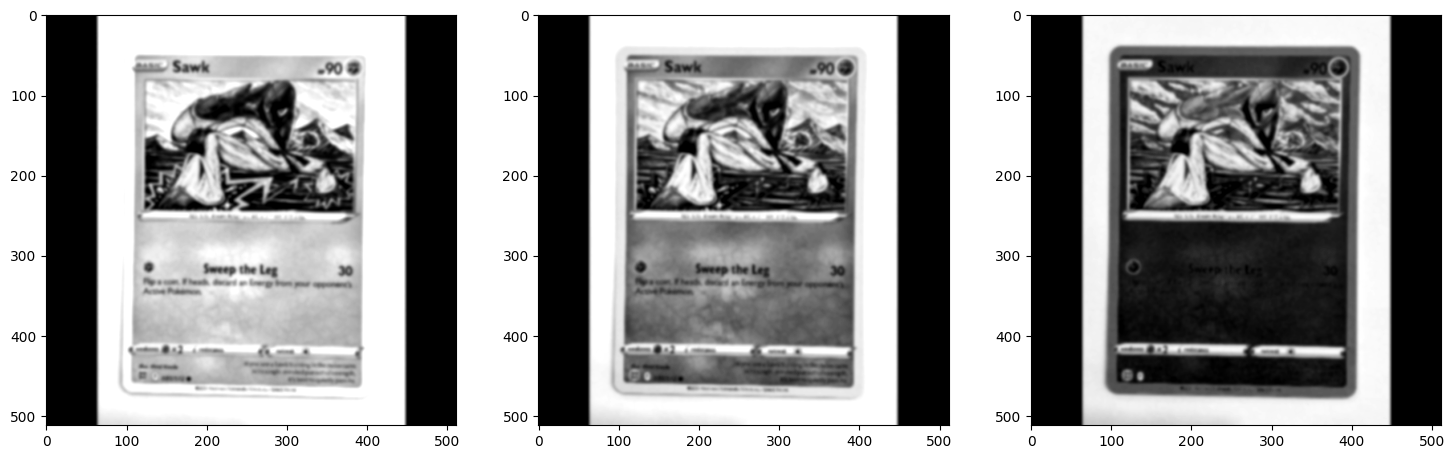

In [87]:
show_channels(np.stack([img_r, img_g, img_b], axis=2))

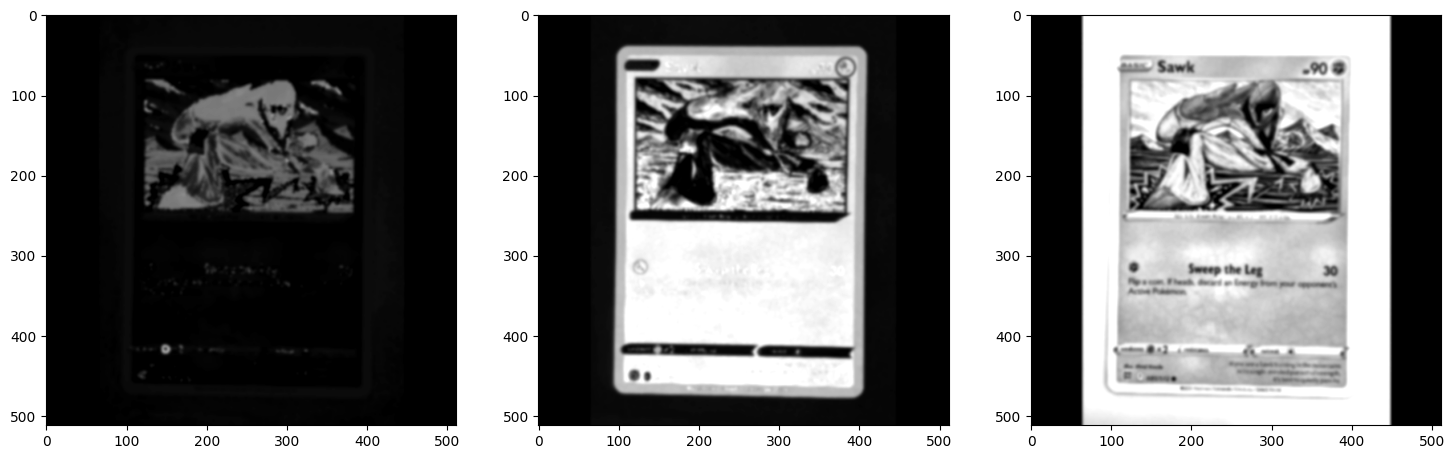

In [88]:
show_channels(np.stack([img_h, img_s, img_v], axis=2))

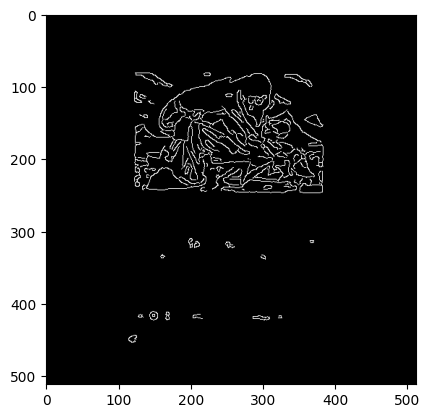

In [89]:
edge1 = cv2.Canny(img_h, 50, 100)
# edge1[700:720, 710:720]
show_grey(edge1)

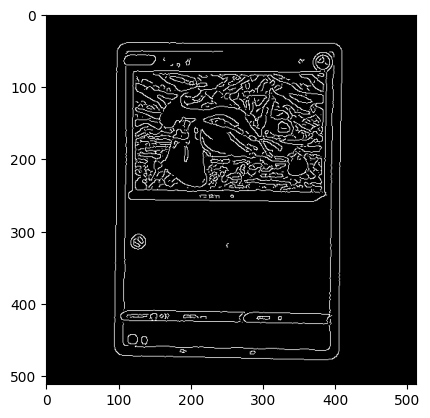

In [90]:
edge2 = cv2.Canny(img_s, 50, 100)
show_grey(edge2)

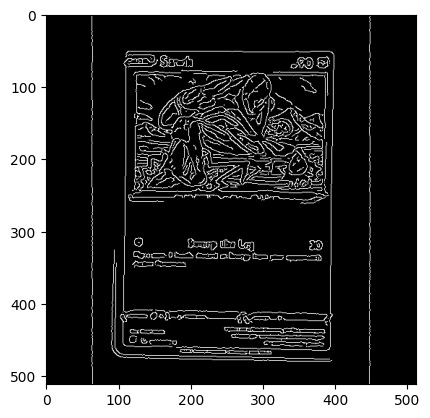

In [91]:
edge3 = cv2.Canny(img_v, 50, 100)
show_grey(edge3)

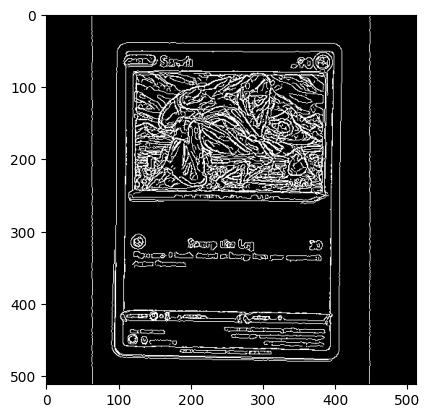

In [92]:
edge_all = cv2.max(cv2.max(edge1, edge2), edge3)
# edge_all.max()
show_grey(edge_all)

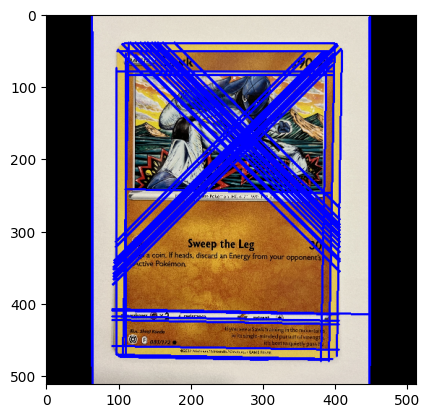

In [93]:
line_img = img.copy()
# lines = cv2.HoughLinesP(edge_all, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
lines = cv2.HoughLinesP(edge_all, 1, np.pi / 180, threshold=150, maxLineGap=1000, minLineLength=100)
# print(lines)
if lines is not None:
    for x1, y1, x2, y2 in lines.squeeze(axis=1):
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.imshow(line_img)

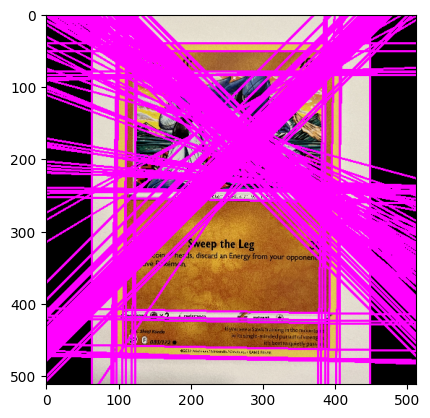

In [94]:
line_img = img.copy()
# lines = cv2.HoughLinesP(edge_all, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
lines = cv2.HoughLines(edge_all, rho=1, theta=np.pi / 180, threshold=150)
lines
for line in lines:
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

plt.imshow(line_img)

In [95]:
contours, hierarchy = cv2.findContours(edge_all, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

In [96]:
smoothed = smooth_contours(contours, epsilon=0.5)
len(smoothed)

3

In [97]:
smoothed = remove_short_contours(smoothed)
len(smoothed)

3

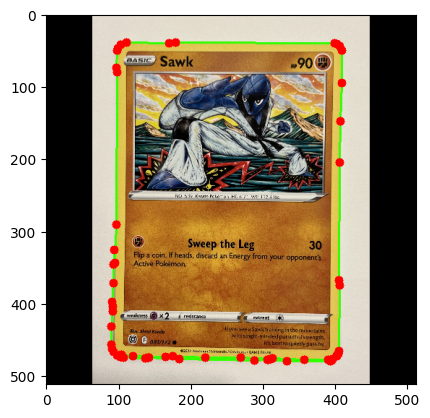

In [98]:
draw_contour(img, smoothed[0])

In [99]:
with open(str(PROJECT_PATH / "data/base_contour.pickle"), mode="rb") as f:
    base_contour = pickle.load(f)
base_contour

array([[[  36,   32]],

       [[  26,   42]],

       [[  19,   56]],

       [[  19,  982]],

       [[  27,  997]],

       [[  35, 1005]],

       [[  46, 1011]],

       [[ 701, 1011]],

       [[ 712, 1005]],

       [[ 722,  994]],

       [[ 727,  984]],

       [[ 727,   53]],

       [[ 721,   42]],

       [[ 712,   33]],

       [[ 697,   26]],

       [[  49,   26]]], dtype=int32)

In [100]:
find_rectangle_contours(smoothed, base_contour)[0][0]

array([[[103,  42]],

       [[ 99,  47]],

       [[ 98,  50]],

       [[ 97,  74]],

       [[ 98,  80]],

       [[ 97, 291]],

       [[ 95, 344]],

       [[ 94, 326]],

       [[ 94, 345]],

       [[ 93, 346]],

       [[ 93, 372]],

       [[ 91, 398]],

       [[ 92, 404]],

       [[ 92, 411]],

       [[ 90, 432]],

       [[ 90, 457]],

       [[ 91, 463]],

       [[ 93, 467]],

       [[ 98, 472]],

       [[102, 474]],

       [[107, 475]],

       [[137, 476]],

       [[142, 475]],

       [[184, 477]],

       [[288, 479]],

       [[307, 478]],

       [[333, 480]],

       [[393, 480]],

       [[395, 479]],

       [[393, 480]],

       [[333, 480]],

       [[306, 478]],

       [[288, 479]],

       [[184, 477]],

       [[141, 475]],

       [[137, 476]],

       [[107, 475]],

       [[103, 474]],

       [[100, 472]],

       [[104, 471]],

       [[120, 473]],

       [[165, 474]],

       [[175, 473]],

       [[220, 475]],

       [[269, 475]],

       [[3

In [101]:
best_fit_contour = find_rectangle_contours(smoothed, base_contour)[0][0]
best_fit_contour = cv2.convexHull(best_fit_contour)
best_fit_contour

array([[[409,  95]],

       [[406, 375]],

       [[405, 466]],

       [[404, 470]],

       [[402, 473]],

       [[395, 479]],

       [[393, 480]],

       [[333, 480]],

       [[184, 477]],

       [[137, 476]],

       [[107, 475]],

       [[102, 474]],

       [[ 98, 472]],

       [[ 93, 467]],

       [[ 91, 463]],

       [[ 90, 457]],

       [[ 90, 432]],

       [[ 97,  74]],

       [[ 98,  50]],

       [[ 99,  47]],

       [[103,  42]],

       [[111,  39]],

       [[179,  39]],

       [[399,  40]],

       [[402,  41]],

       [[406,  44]],

       [[409,  50]]], dtype=int32)

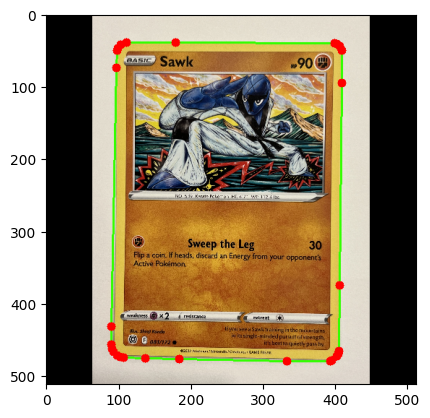

In [102]:
draw_contour(img, best_fit_contour)

In [103]:
def angle_between(pt0, pt1, pt2) -> float:
    B = pt0[0]
    C = pt1[0]
    F = pt2[0]
    FC = F - C
    BC = B - C
    FC_norm = FC / np.linalg.norm(FC)
    BC_norm = BC / np.linalg.norm(BC)
    dot_product = np.dot(FC_norm, BC_norm)
    beta = np.arccos(dot_product)
    return np.degrees(beta)

In [104]:
def remove_flat_points(contour, threshold: float = 3) -> np.ndarray:
    pt_count = len(contour)
    results = []

    for i in range(2, pt_count + 1):
        pts0 = contour[i - 2]
        pts1 = contour[i - 1]
        pts2 = contour[i % pt_count]
        angle = angle_between(pts0, pts1, pts2)
        if np.abs(180 - angle) >= threshold:
            results.append(contour[i - 1])

    return np.array(results)

In [105]:
def get_coeffs(pt0, pt1):
    points = [pt0, pt1]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    s, i = np.linalg.lstsq(A, y_coords, rcond=None)[0]
    a = s
    b = -1.0
    c = -i
    return a, b, c

In [106]:
get_coeffs(np.array([2, 1.5]), np.array([8.5, 4]))

(0.3846153846153845, -1.0, -0.7307692307692322)

In [107]:
def get_corners_from_contour(contour):
    pt_count = len(contour)
    ranks = []
    for i in range(0, pt_count):
        pt0 = contour[i][0]
        pt1 = contour[(i + 1) % pt_count][0]
        distance = np.linalg.norm(pt0 - pt1)
        ranks.append([[pt0, pt1], distance, i])

    ranks = sorted(ranks, key=lambda x: x[1], reverse=True)[:4]
    ranks = sorted(ranks, key=lambda x: x[2], reverse=False)
    corners = []
    for i in range(4):
        edge0 = ranks[i][0]
        edge1 = ranks[(i + 1) % 4][0]

        a1, b1, c1 = get_coeffs(edge0[0], edge0[1])
        a2, b2, c2 = get_coeffs(edge1[0], edge1[1])

        A = np.array([[a1, b1], [a2, b2]])
        B = np.array([c1, c2])

        intersect_pt = np.linalg.solve(A, B)
        corners.append(intersect_pt)

    return np.expand_dims(np.array(corners), axis=1).astype(np.int32)

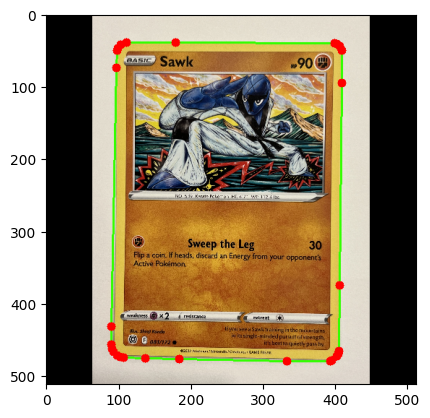

In [108]:
draw_contour(img, best_fit_contour)

In [109]:
best_fit_contour

array([[[409,  95]],

       [[406, 375]],

       [[405, 466]],

       [[404, 470]],

       [[402, 473]],

       [[395, 479]],

       [[393, 480]],

       [[333, 480]],

       [[184, 477]],

       [[137, 476]],

       [[107, 475]],

       [[102, 474]],

       [[ 98, 472]],

       [[ 93, 467]],

       [[ 91, 463]],

       [[ 90, 457]],

       [[ 90, 432]],

       [[ 97,  74]],

       [[ 98,  50]],

       [[ 99,  47]],

       [[103,  42]],

       [[111,  39]],

       [[179,  39]],

       [[399,  40]],

       [[402,  41]],

       [[406,  44]],

       [[409,  50]]], dtype=int32)

In [110]:
get_corners_from_contour(best_fit_contour)

array([[[404, 481]],

       [[ 89, 475]],

       [[ 97,  38]],

       [[409,  40]]], dtype=int32)

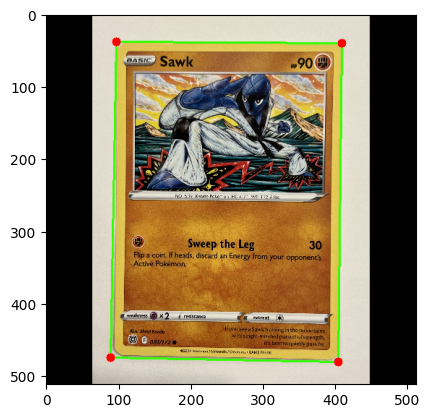

In [111]:
draw_contour(img, get_corners_from_contour(best_fit_contour))

In [112]:
best_fit_contour

array([[[409,  95]],

       [[406, 375]],

       [[405, 466]],

       [[404, 470]],

       [[402, 473]],

       [[395, 479]],

       [[393, 480]],

       [[333, 480]],

       [[184, 477]],

       [[137, 476]],

       [[107, 475]],

       [[102, 474]],

       [[ 98, 472]],

       [[ 93, 467]],

       [[ 91, 463]],

       [[ 90, 457]],

       [[ 90, 432]],

       [[ 97,  74]],

       [[ 98,  50]],

       [[ 99,  47]],

       [[103,  42]],

       [[111,  39]],

       [[179,  39]],

       [[399,  40]],

       [[402,  41]],

       [[406,  44]],

       [[409,  50]]], dtype=int32)

In [113]:
remove_flat_points(best_fit_contour)

array([[[405, 466]],

       [[404, 470]],

       [[402, 473]],

       [[395, 479]],

       [[393, 480]],

       [[107, 475]],

       [[102, 474]],

       [[ 98, 472]],

       [[ 93, 467]],

       [[ 91, 463]],

       [[ 90, 457]],

       [[ 98,  50]],

       [[ 99,  47]],

       [[103,  42]],

       [[111,  39]],

       [[399,  40]],

       [[402,  41]],

       [[406,  44]],

       [[409,  50]]], dtype=int32)

In [114]:
best_fit_contour = remove_flat_points(best_fit_contour)

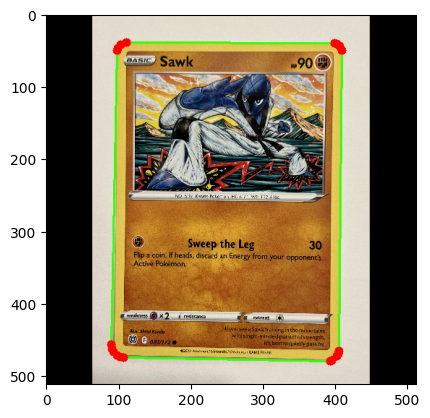

In [115]:
draw_contour(img, best_fit_contour)

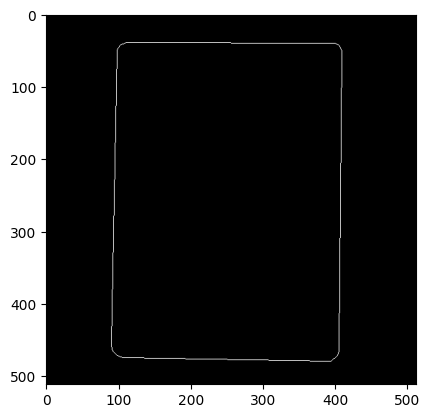

In [116]:
mask = np.zeros_like(img)

# Step 4: Fill the detected contours on the mask with white color
cv2.drawContours(mask, [best_fit_contour], -1, (255, 255, 255), thickness=1)
plt.imshow(mask)

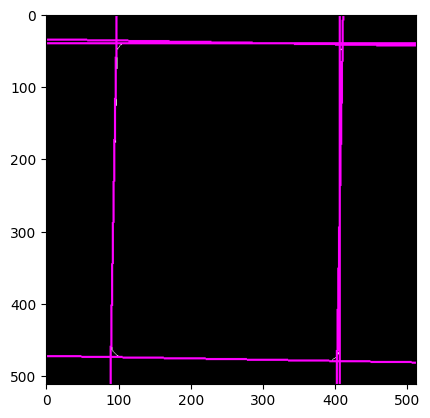

In [117]:
line_img = mask.copy()
lines = cv2.HoughLines(mask[:, :, 0], rho=1, theta=np.pi / 180, threshold=100)
lines
for line in lines:
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

plt.imshow(line_img)